## 3D image classification from CT scans

### Setup

In [1]:
import os
import zipfile
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from scipy import ndimage
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
from torchvision import datasets,transforms
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Downloading the MosMedData: Chest CT Scans with COVID-19 Related Findings

In [ ]:
!wget https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-0.zip
!wget https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-23.zip

In [4]:
os.makedirs("MosMedData")

with zipfile.ZipFile("CT-0.zip", "r") as z_fp:
    z_fp.extractall("./MosMedData/")

with zipfile.ZipFile("CT-23.zip", "r") as z_fp:
    z_fp.extractall("./MosMedData/")

### Loading data and preprocessing

In [5]:
class MosMedDataDataset(Dataset):
    def __init__(self, root, transform=None, target_transform=None, train=True):
        self.root = root
        self.transform = transform
        self.target_transform = target_transform
        self.train = train

        normal_scan_paths = glob.glob(os.path.join(self.root, "CT-0/*.nii.gz"))
        abnormal_scan_paths = glob.glob(os.path.join(self.root, "CT-23/*.nii.gz"))

        normal_labels = torch.tensor([0 for _ in range(len(normal_scan_paths))])
        abnormal_labels = torch.tensor([1 for _ in range(len(abnormal_scan_paths))])

        if train:
            self.files = abnormal_scan_paths[:70] + normal_scan_paths[:70]
            self.labels = torch.concat((abnormal_labels[:70], normal_labels[:70]), dim=0)
        else:
            self.files = abnormal_scan_paths[70:] + normal_scan_paths[70:]
            self.labels = torch.concat((abnormal_labels[70:], normal_labels[70:]), dim=0)

        self.shuffle()


    def shuffle(self):
        indices = list(range(len(self.files)))
        random.seed(42)
        random.shuffle(indices)
        self.files = [self.files[i] for i in indices]
        self.labels = [self.labels[i] for i in indices]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        image_path = self.files[index]
        image = nib.load(image_path).get_fdata()
        label = self.labels[index]

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [6]:
def normalize(volume):
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume

In [7]:
def resize_volume(img):
    desired_depth = 64
    desired_width = 128
    desired_height = 128

    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]

    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height

    img = ndimage.rotate(img, 90, reshape=False)

    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

### Data augmentation

In [8]:
def random_rotate(volume):
    angles = [-20, -10, -5, 5, 10, 20]

    angle = random.choice(angles)

    volume = ndimage.rotate(volume, angle, reshape=False)
    volume[volume < 0] = 0
    volume[volume > 1] = 1
    return volume

### Build train and validation datasets

In [9]:
torch.manual_seed(42)

image_size = (64, 128, 128)
batch_size = 8
data_path = "MosMedData"

train_transform = transforms.Compose([
    transforms.Lambda(normalize),
    transforms.Lambda(resize_volume),
    transforms.Lambda(random_rotate),
    transforms.ToTensor(),
    transforms.Lambda(lambda volume: volume.unsqueeze(0))])

test_transform = transforms.Compose([
    transforms.Lambda(normalize),
    transforms.Lambda(resize_volume),
    transforms.ToTensor(),
    transforms.Lambda(lambda volume: volume.unsqueeze(0))])

train_dataset = MosMedDataDataset(data_path, train_transform, train=True)
test_dataset = MosMedDataDataset(data_path, test_transform, train=False)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

Dimension of the CT scan is: (128, 128, 64, 1)


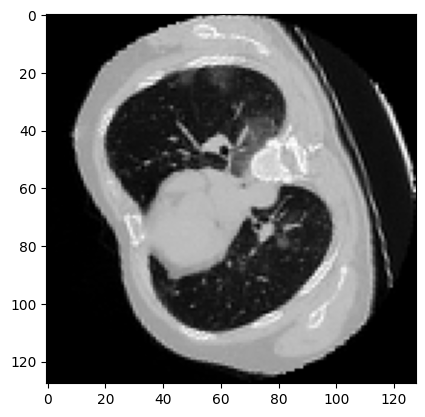

In [40]:
image = None
for images, labels in train_loader:
    image = np.transpose(images[0].numpy(), (3, 2, 1, 0))
    print("Dimension of the CT scan is:", image.shape)
    plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")
    break
plt.show()

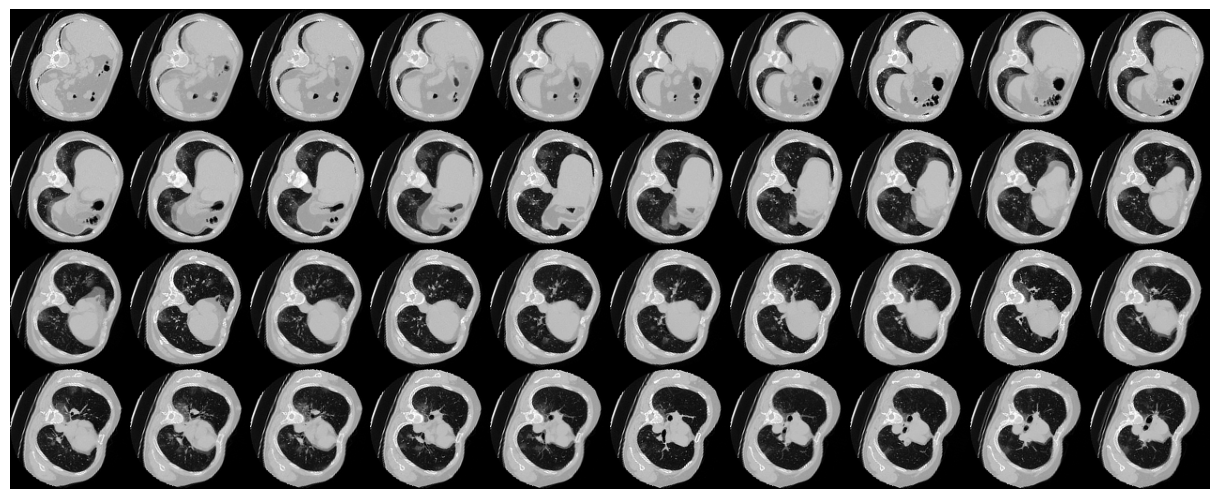

In [41]:
def plot_slices(num_rows, num_columns, width, height, data):
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


plot_slices(4, 10, 128, 128, image[:, :, :40])


### Define a 3D convolutional neural network

In [10]:
class CNN3D(nn.Module):
    def __init__(self, in_channels: int, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.layers = nn.ModuleList()

        channels = [in_channels, 64, 64, 128, 256]
        for index, size in enumerate(channels[:-1]):
            self.layers.append(nn.Sequential(
                nn.Conv3d(in_channels=size,
                          out_channels=channels[index+1], kernel_size=3),
                nn.ReLU(),
                nn.MaxPool3d(kernel_size=2),
                nn.BatchNorm3d(channels[index+1])))

        self.layers.append(nn.Sequential(
            nn.AdaptiveAvgPool3d(1),
            nn.Flatten(),
            nn.Linear(in_features=256, out_features=512),
            nn.ReLU(),
            nn.Dropout1d(p=0.3),
            nn.Linear(in_features=512, out_features=1),
            nn.Sigmoid()))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for layer in self.layers:
            x = layer(x)
        return x

In [11]:
model = CNN3D(in_channels=1)

In [42]:
summary(model, input_size=(1, 64, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1     [-1, 64, 62, 126, 126]           1,792
              ReLU-2     [-1, 64, 62, 126, 126]               0
         MaxPool3d-3       [-1, 64, 31, 63, 63]               0
       BatchNorm3d-4       [-1, 64, 31, 63, 63]             128
            Conv3d-5       [-1, 64, 29, 61, 61]         110,656
              ReLU-6       [-1, 64, 29, 61, 61]               0
         MaxPool3d-7       [-1, 64, 14, 30, 30]               0
       BatchNorm3d-8       [-1, 64, 14, 30, 30]             128
            Conv3d-9      [-1, 128, 12, 28, 28]         221,312
             ReLU-10      [-1, 128, 12, 28, 28]               0
        MaxPool3d-11       [-1, 128, 6, 14, 14]               0
      BatchNorm3d-12       [-1, 128, 6, 14, 14]             256
           Conv3d-13       [-1, 256, 4, 12, 12]         884,992
             ReLU-14       [-1, 256, 4,

### Train model

In [13]:
def run(model, device, num_epochs, initial_learning_rate=1e-3, normal_init=False):
  torch.manual_seed(42)
  model.to(device=device)

  initial_learning_rate = initial_learning_rate
  num_epochs = num_epochs

  def init_weight(m):
    if isinstance(m, nn.Linear):
      nn.init.kaiming_normal_(m.weight)
      nn.init.zeros_(m.bias)

  if normal_init:
    model.apply(init_weight)

  criterion = torch.nn.BCELoss()
  optimizer = optim.Adam(model.parameters(), lr=initial_learning_rate)
  scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.96)

  best_accuracy = 0.0
  patience = 5
  epoch_num_improve = 0

  train_losses = []
  train_accuracies = []
  test_losses = []
  test_accuracies = []

  for epoch in range(num_epochs):

    model.train()
    train_loss = 0.0
    train_correct = 0

    for images, labels in tqdm(train_loader):
      images = images.to(device=device)
      labels = labels.float().to(device=device).unsqueeze(1)

      output = model(images)
      loss = criterion(output, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      train_loss += loss.item()

      predicted = (output > 0.5).float()
      train_correct += (predicted == labels).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = train_correct / len(train_dataset)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    scheduler.step()

    model.eval()
    test_loss = 0
    test_correct = 0

    with torch.no_grad():
      for images, labels in test_loader:
        images = images.to(device=device)
        labels = labels.float().to(device=device).unsqueeze(1)

        output = model(images)
        loss = criterion(output, labels)

        test_loss += loss.item()

      predicted = (output > 0.5).float()
      test_correct += (predicted == labels).sum().item()

      test_loss /= len(test_loader)
      test_accuracy = test_correct / len(test_dataset)
      test_losses.append(test_loss)
      train_accuracies.append(test_accuracy)

    print(f"Epoch: {epoch + 1}/{num_epochs} | Train loss: {train_loss:.4f} | Train Acc: {train_accuracy:.4f} | Test loss: {test_loss:.4f} | Test Acc: {test_accuracy:.4f}")

    if test_accuracy > best_accuracy:
      best_accuracy = test_accuracy
      epoch_num_improve = 0
      torch.save(model.state_dict(), "best_model.pth")
    else:
      epoch_num_improve += 1
      if epoch_num_improve > patience:
        print(f"Early stopping, best accuracy {best_accuracy}")
        break
  return train_losses, train_accuracies, test_losses, test_accuracies

In [14]:
train_losses, train_accuracies, test_losses, test_accuracies = run(model, device, num_epochs=10, initial_learning_rate=1e-4, normal_init=True)

100%|██████████| 18/18 [06:00<00:00, 20.05s/it]


Epoch: 1/10 | Train loss: 0.7915 | Train Acc: 0.5500 | Test loss: 0.7982 | Test Acc: 0.0333


100%|██████████| 18/18 [05:59<00:00, 19.97s/it]


Epoch: 2/10 | Train loss: 0.6592 | Train Acc: 0.6357 | Test loss: 1.9949 | Test Acc: 0.0333


100%|██████████| 18/18 [05:56<00:00, 19.81s/it]


Epoch: 3/10 | Train loss: 0.6336 | Train Acc: 0.6357 | Test loss: 1.0251 | Test Acc: 0.0333


100%|██████████| 18/18 [05:54<00:00, 19.71s/it]


Epoch: 4/10 | Train loss: 0.6326 | Train Acc: 0.6643 | Test loss: 0.5908 | Test Acc: 0.0333


100%|██████████| 18/18 [05:49<00:00, 19.39s/it]


Epoch: 5/10 | Train loss: 0.5840 | Train Acc: 0.6571 | Test loss: 0.5980 | Test Acc: 0.0500


100%|██████████| 18/18 [05:52<00:00, 19.60s/it]


Epoch: 6/10 | Train loss: 0.5705 | Train Acc: 0.6429 | Test loss: 0.6782 | Test Acc: 0.0500


100%|██████████| 18/18 [05:50<00:00, 19.49s/it]


Epoch: 7/10 | Train loss: 0.5347 | Train Acc: 0.7643 | Test loss: 0.6116 | Test Acc: 0.0500


100%|██████████| 18/18 [05:47<00:00, 19.30s/it]


Epoch: 8/10 | Train loss: 0.5689 | Train Acc: 0.6571 | Test loss: 0.6472 | Test Acc: 0.0333


100%|██████████| 18/18 [05:52<00:00, 19.56s/it]


Epoch: 9/10 | Train loss: 0.5331 | Train Acc: 0.7214 | Test loss: 0.6148 | Test Acc: 0.0500


100%|██████████| 18/18 [05:56<00:00, 19.79s/it]


Epoch: 10/10 | Train loss: 0.4795 | Train Acc: 0.7214 | Test loss: 0.6051 | Test Acc: 0.0333


### Visualizing model performance

In [25]:
def plot(ax, train_data, test_data, title, y_label):
    ax.plot(train_data)
    ax.plot(test_data)
    ax.set_title(title)
    ax.set_ylabel(y_label)
    ax.set_xlabel("epoch")
    ax.legend(["train", "test"], loc="upper left")

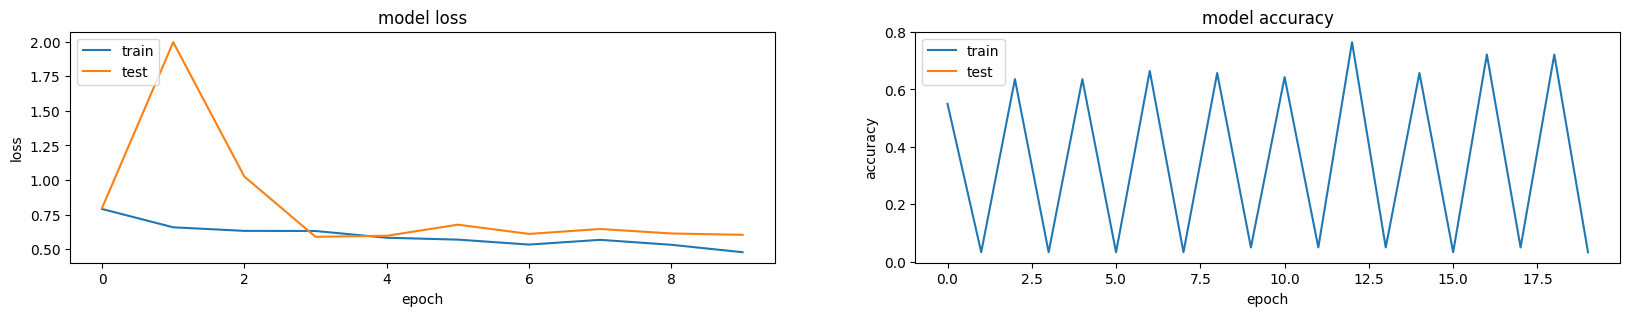

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()
plot(ax[0], train_losses, test_losses, title="model loss", y_label="loss")
plot(ax[1], train_accuracies, test_accuracies, title="model accuracy", y_label="accuracy")
plt.show()

### Make predictions on a single CT scan

In [39]:
loaded_model = CNN3D(in_channels=1)
loaded_model.load_state_dict(torch.load("best_model.pth"))

loaded_model.eval()
with torch.no_grad():
  for images, labels in test_loader:
    images = images.to(device=device)
    prediction = model(images)[0]
    scores = [1 - prediction, prediction]

    if labels[0] == 0:
      print(f"Actual Label: Normal")
    else:
      print(f"Actual Label: Abnormal")
    break

class_names = ["normal", "abnormal"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that CT scan is %s"
        % ((100 * score), name)
    )

Actual Label: Normal
This model is 62.28 percent confident that CT scan is normal
This model is 37.72 percent confident that CT scan is abnormal
